<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SemiSuperVisedLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from seaborn import heatmap
from sklearn.utils import class_weight

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !pfad angepasst wegen neuem account!
data = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['bands']
labels = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['lulc']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])
#x_test = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/public_test.npz')['bands']

In [5]:
# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

In [6]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

In [7]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

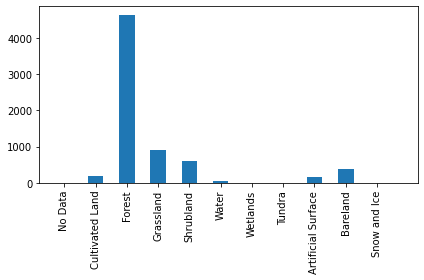

In [8]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [9]:
!pip install catboost
from catboost import CatBoostClassifier

In [10]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=100, random_seed=42, logging_level='Verbose')
cbm.fit(x_train, y_train)

0:	learn: 1.6601692	total: 205ms	remaining: 20.3s
1:	learn: 1.4845736	total: 340ms	remaining: 16.7s
2:	learn: 1.3504518	total: 489ms	remaining: 15.8s
3:	learn: 1.2532687	total: 636ms	remaining: 15.3s
4:	learn: 1.1706039	total: 766ms	remaining: 14.6s
5:	learn: 1.1039608	total: 905ms	remaining: 14.2s
6:	learn: 1.0474649	total: 1.03s	remaining: 13.8s
7:	learn: 0.9988784	total: 1.17s	remaining: 13.4s
8:	learn: 0.9562487	total: 1.29s	remaining: 13.1s
9:	learn: 0.9191706	total: 1.42s	remaining: 12.8s
10:	learn: 0.8875761	total: 1.56s	remaining: 12.6s
11:	learn: 0.8618120	total: 1.69s	remaining: 12.4s
12:	learn: 0.8376863	total: 1.82s	remaining: 12.2s
13:	learn: 0.8141026	total: 1.95s	remaining: 12s
14:	learn: 0.7946817	total: 2.09s	remaining: 11.8s
15:	learn: 0.7748553	total: 2.22s	remaining: 11.6s
16:	learn: 0.7585419	total: 2.35s	remaining: 11.5s
17:	learn: 0.7436088	total: 2.48s	remaining: 11.3s
18:	learn: 0.7318218	total: 2.62s	remaining: 11.2s
19:	learn: 0.7199553	total: 2.75s	remaining

In [11]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 84.3089313965195
F1-Score: [52.29681979 92.70245304 66.70360111 49.67880086 66.66666667 60.
 83.29177057]
              precision    recall  f1-score   support

           1       0.80      0.39      0.52       190
           2       0.88      0.97      0.93      4637
           3       0.67      0.67      0.67       900
           4       0.73      0.38      0.50       616
           5       1.00      0.50      0.67        46
           8       0.84      0.47      0.60       174
           9       0.81      0.86      0.83       390

    accuracy                           0.84      6953
   macro avg       0.82      0.60      0.67      6953
weighted avg       0.84      0.84      0.83      6953



Validation

Accuracy: 80.448533640023
F1-Score: [41.09589041 91.40752864 59.24276169 35.24229075 58.82352941 40.
 74.03846154]
              precision    recall  f1-score   support

           1       0.60      0.31      0.41        48
           2       0.87      0.96      

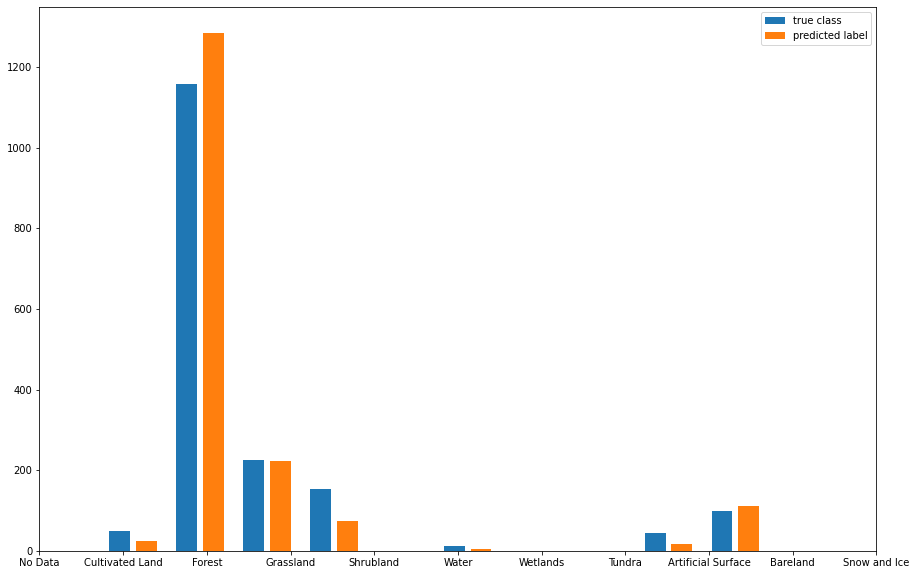

In [12]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

In [13]:
# fit the model on full unlabelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

0:	learn: 1.6570101	total: 144ms	remaining: 14.2s
1:	learn: 1.4789320	total: 286ms	remaining: 14s
2:	learn: 1.3448165	total: 436ms	remaining: 14.1s
3:	learn: 1.2443726	total: 571ms	remaining: 13.7s
4:	learn: 1.1623761	total: 708ms	remaining: 13.5s
5:	learn: 1.0940929	total: 841ms	remaining: 13.2s
6:	learn: 1.0380999	total: 975ms	remaining: 13s
7:	learn: 0.9908858	total: 1.11s	remaining: 12.7s
8:	learn: 0.9487823	total: 1.25s	remaining: 12.7s
9:	learn: 0.9167833	total: 1.39s	remaining: 12.6s
10:	learn: 0.8846229	total: 1.53s	remaining: 12.4s
11:	learn: 0.8581981	total: 1.68s	remaining: 12.3s
12:	learn: 0.8347148	total: 1.81s	remaining: 12.1s
13:	learn: 0.8130806	total: 1.94s	remaining: 11.9s
14:	learn: 0.7936356	total: 2.08s	remaining: 11.8s
15:	learn: 0.7754164	total: 2.21s	remaining: 11.6s
16:	learn: 0.7573018	total: 2.36s	remaining: 11.5s
17:	learn: 0.7428071	total: 2.48s	remaining: 11.3s
18:	learn: 0.7311917	total: 2.62s	remaining: 11.2s
19:	learn: 0.7193563	total: 2.75s	remaining: 

In [14]:
# predict labels for unlabelled data
transformed_data = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[4]))
predicted_labels = cbm.predict(transformed_data[labels == 0]).reshape(-1)
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

In [15]:
# full data
x_train, x_val, y_train, y_val = preprocess(data, new_labels)
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (8000, 72) (8000,), validation: (2000, 72) (2000,)'

In [16]:
# fit the model on full data with new labels
cbm.fit(x_train, y_train)

0:	learn: 1.6442959	total: 139ms	remaining: 13.8s
1:	learn: 1.4659800	total: 278ms	remaining: 13.6s
2:	learn: 1.3259379	total: 413ms	remaining: 13.4s
3:	learn: 1.2292418	total: 549ms	remaining: 13.2s
4:	learn: 1.1440761	total: 689ms	remaining: 13.1s
5:	learn: 1.0729942	total: 821ms	remaining: 12.9s
6:	learn: 1.0145400	total: 951ms	remaining: 12.6s
7:	learn: 0.9655785	total: 1.09s	remaining: 12.5s
8:	learn: 0.9205841	total: 1.22s	remaining: 12.3s
9:	learn: 0.8835288	total: 1.34s	remaining: 12.1s
10:	learn: 0.8528315	total: 1.47s	remaining: 11.9s
11:	learn: 0.8250368	total: 1.6s	remaining: 11.8s
12:	learn: 0.7993238	total: 1.74s	remaining: 11.6s
13:	learn: 0.7761850	total: 1.87s	remaining: 11.5s
14:	learn: 0.7560408	total: 2s	remaining: 11.4s
15:	learn: 0.7375523	total: 2.13s	remaining: 11.2s
16:	learn: 0.7210793	total: 2.27s	remaining: 11.1s
17:	learn: 0.7056824	total: 2.39s	remaining: 10.9s
18:	learn: 0.6919654	total: 2.52s	remaining: 10.7s
19:	learn: 0.6781475	total: 2.65s	remaining: 

In [17]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 85.675
F1-Score: [50.         93.4914361  70.04784689 47.83549784 64.70588235 58.97435897
 84.0981857 ]
              precision    recall  f1-score   support

           1       0.78      0.37      0.50       193
           2       0.90      0.98      0.93      5452
           3       0.70      0.70      0.70      1041
           4       0.74      0.35      0.48       624
           5       1.00      0.48      0.65        46
           8       0.81      0.46      0.59       198
           9       0.80      0.88      0.84       446

    accuracy                           0.86      8000
   macro avg       0.82      0.60      0.67      8000
weighted avg       0.85      0.86      0.84      8000



Validation

Accuracy: 82.6
F1-Score: [33.8028169  92.10342418 64.98054475 34.54545455 73.68421053 47.88732394
 76.54320988]
              precision    recall  f1-score   support

           1       0.52      0.25      0.34        48
           2       0.88      0.97      0.92 

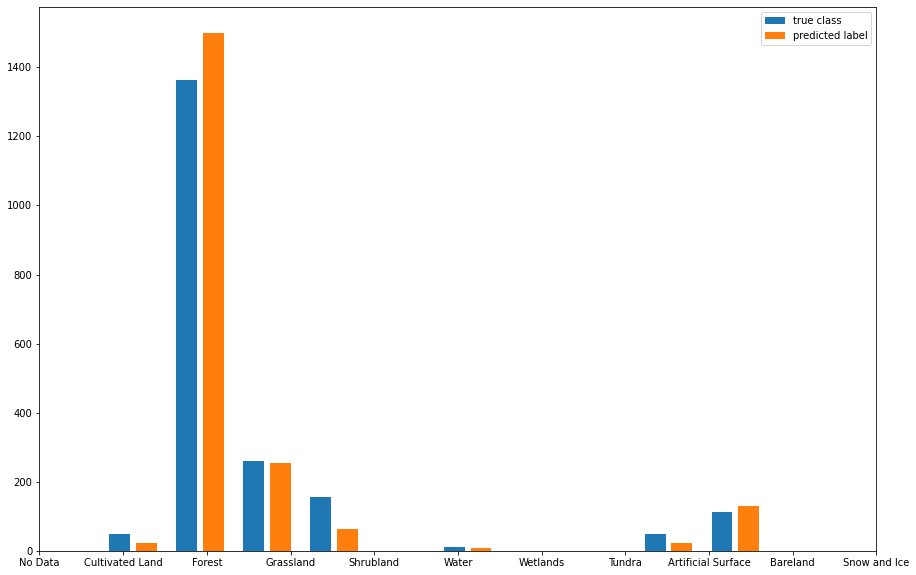

In [18]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()